In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/03_MultiCenter/input/"
benign_dir = os.listdir(train_dir +  'Benign')
cancer_dir = os.listdir(train_dir + 'Cancer')

In [ ]:
print(len(benign_dir, cancer_dir))

In [ ]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 12559 files belonging to 2 classes.
Using 10048 files for training.
Found 12559 files belonging to 2 classes.
Using 2511 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Benign', 'Cancer']


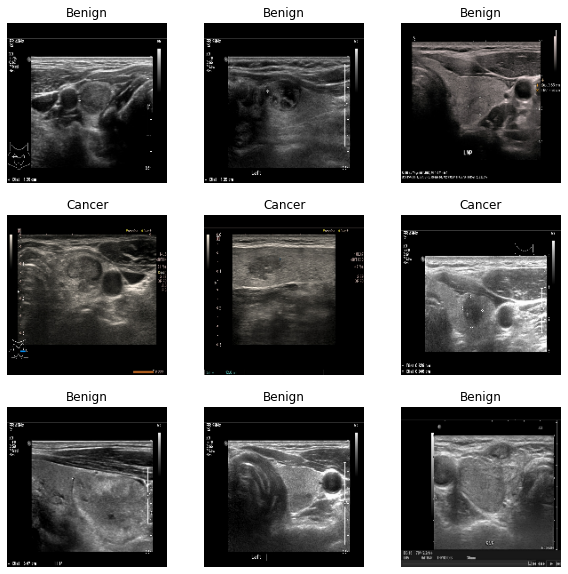

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

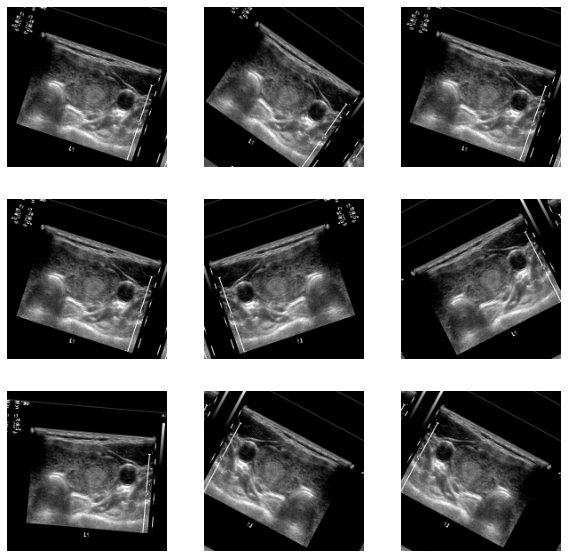

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

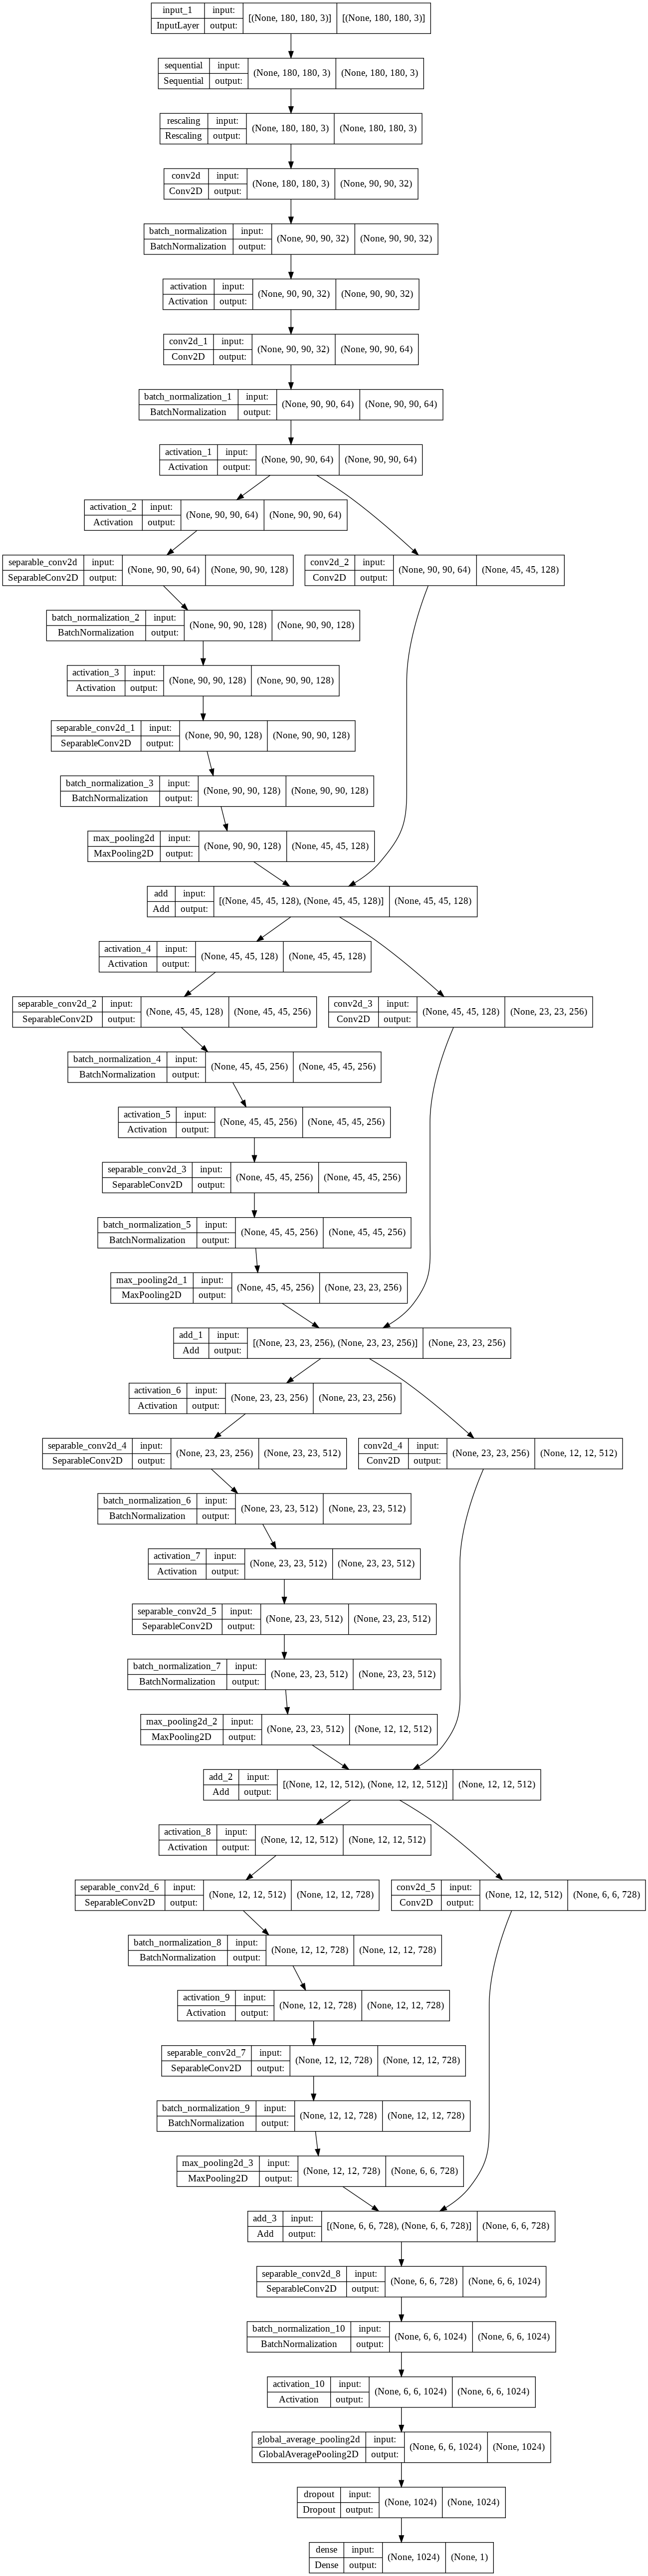

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
314/314 [==============================] - 1477s 5s/step - loss: 0.5414 - accuracy: 0.7796 - val_loss: 0.5079 - val_accuracy: 0.7961
Epoch 2/50
314/314 [==============================] - 67s 210ms/step - loss: 0.5160 - accuracy: 0.7886 - val_loss: 0.5376 - val_accuracy: 0.7961
Epoch 3/50
314/314 [==============================] - 66s 209ms/step - loss: 0.5067 - accuracy: 0.7912 - val_loss: 0.4905 - val_accuracy: 0.8041
Epoch 4/50
314/314 [==============================] - 66s 209ms/step - loss: 0.5043 - accuracy: 0.7953 - val_loss: 0.5067 - val_accuracy: 0.7961
Epoch 5/50
314/314 [==============================] - 67s 209ms/step - loss: 0.4961 - accuracy: 0.7976 - val_loss: 0.5411 - val_accuracy: 0.7993
Epoch 6/50
314/314 [==============================] - 67s 209ms/step - loss: 0.4913 - accuracy: 0.8002 - val_loss: 0.9665 - val_accuracy: 0.7961
Epoch 7/50
314/314 [==============================] - 67s 210ms/step - loss: 0.4901 - accuracy: 0.7998 - val_loss: 0.5540 - val_acc

In [ ]:
cancer = 'Cancer/'
benign = 'Benign/'

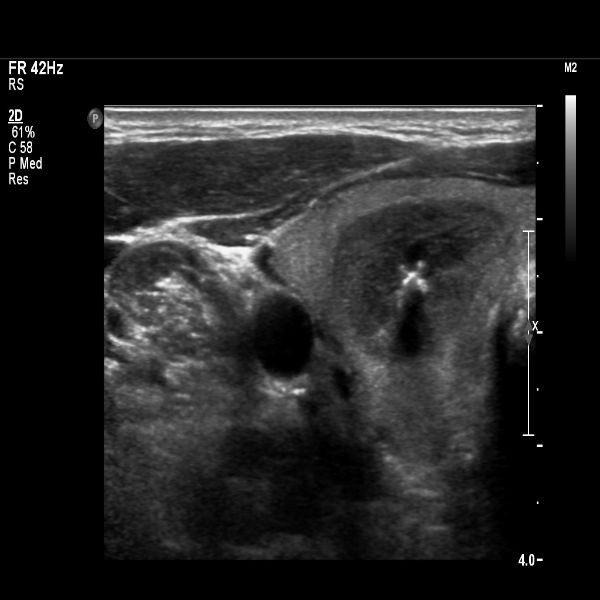

This image is 0.93 percent benign and 99.07 percent cancer.


In [ ]:
from google.colab.patches import cv2_imshow
import cv2

img = keras.preprocessing.image.load_img(
    cancer + cancer_dir[412], target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
src = cv2.imread('Benign/B_001-0002-1.0.jpg')
resize_img = cv2.resize(src, (600, 600))
cv2_imshow(resize_img)
cv2.waitKey()

print(
    "This image is %.2f percent benign and %.2f percent cancer."
    % (100 * (1 - score), 100 * score)
)
